In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils import create_level, define_reward, process_state, perform_action, show_match

In [2]:
H = 15
W = 15
NUM_EPISODES = 100
MAX_STEPS = 200
MONSTER = ['kobold', 'giant bat']
WEAPON = []
PATH = 'kb.pl'

In [3]:
des_file = create_level(width = W, height = H, monsters = MONSTER, weapons = WEAPON, potion = True, armor = False)
print(des_file)
reward_manager = define_reward(monsters = MONSTER)


MAZE: "mylevel", ' '
FLAGS:hardfloor
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION:(0,0,15,15),lit,"ordinary"
WALLIFY
MONSTER:"kobold",random
MONSTER:"goblin",random
MONSTER:"giant bat",random
OBJECT:('!',"full healing"),random



In [4]:
env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               #character="bar-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file,
               reward_manager=reward_manager
               )

/home/daniel/.pyenv/versions/3.9.20/lib/python3.9/site-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


In [5]:
obs = env.reset()
env.render()


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                               -----------------                                
                               |...............|                                
                               |..............B|                                
                               |...............|                                
                               |...............|                                
                               |.....k.........|                                
                               |...............|                                
                               |...!...........|                                
                               |...............|                                
                           

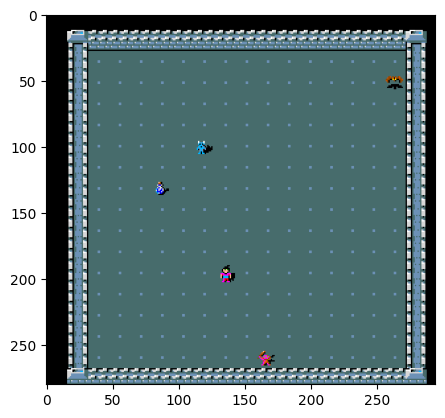

In [ ]:
plt.imshow(obs['pixel'][20:300, 480:775])

Initialize the knowledge base.

In [7]:
KB = Prolog()
KB.consult(PATH)

#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.
- The main goal is to _reach and eat_ the `apple`.

In [8]:

# for i in range(0):
#     print(f'Action performed: {i} {repr(env.actions[i])}')

Episode 100 - 18 steps
End status: TASK_SUCCESSFUL
Final reward: 2.96
After 100 episodes, mean return is 2.6774999999999984
and the total number of winning episodes is 82
the mean number of step per episode is 8.655339805825243
the mean number of step per winning epidose is 15.060975609756097
The rewards of the episodes are: [2.95, 2.96, 2.94, 2.9699999999999998, 2.9699999999999998, 2.96, 2.96, 2.99, 2.96, 2.95, 2.9699999999999998, 2.9699999999999998, 2.9699999999999998, 2.96, 2.95, 2.9699999999999998, 2.94, 2.9699999999999998, 1.98, 2.98, 2.9699999999999998, 2.9699999999999998, 2.9, 2.98, 2.98, 0.99, 2.98, 2.96, 2.96, 2.96, 2.9699999999999998, 2.95, 2.98, 1.99, 2.98, 0.0, 2.9699999999999998, 2.99, 2.9299999999999997, 2.99, 2.98, 2.99, 2.99, 1.98, 2.9699999999999998, 2.98, 2.98, 2.9699999999999998, 2.9699999999999998, 2.98, 0.99, 2.96, 1.99, 2.98, 2.98, 2.98, 2.96, 2.95, 2.9699999999999998, 2.9699999999999998, 2.9699999999999998, 2.96, 1.97, 1.95, 2.9699999999999998, 0.9199999999999999

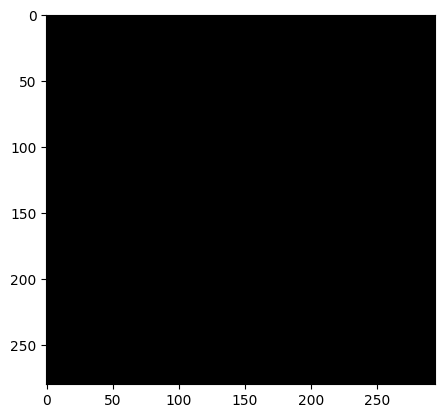

In [9]:
rewards = [] 
step = []
step_win = []
wins = 0
for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb
        process_state(obs, KB, MONSTER)
        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            # print("ACTION: ", action)
        except Exception as e:
            print(e)
            action = None

        # Perform the action in the environment
        if action:
            # print(f"Action from kb: {action}")
            obs, rwd, done, info = perform_action(action, env, KB)
            message = bytes(obs['message']).decode('utf-8').rstrip('\x00')
            # print(message)
            reward += rwd
            ep_states.append(obs['pixel'])
            # env.render()
        else:
            print("ERROR: No action can be performed")
            break

        steps += 1
        step.append(steps)
    
    if info["end_status"].name == "TASK_SUCCESSFUL":
        wins += 1
        step_win.append(steps)

    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode + 1} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')

    rewards.append(reward)

    # reset the environment and retract axioms that may cause errors
    obs = env.reset()
    KB = Prolog()
    KB.consult(PATH)

    # time.sleep(1)


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print(f'and the total number of winning episodes is {wins}')
print(f'the mean number of step per episode is {sum(step)/len(step)}')
print(f'the mean number of step per winning epidose is {sum(step_win)/len(step_win)}')
print("The rewards of the episodes are:", rewards)